In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
class DatasetHandler:

    def __init__(self, filename):
        """
        Reads the data into a dataframe and does initial processing
        """
        assert isinstance(filename, str)
        assert len(filename) > 0

        self._plot = False # controls whether plots should be displayed. Useful for debugging

        try:
            self._df = pd.read_csv(filename)
        except FileNotFoundError:
            print("The file could not be found!")

    def clean_dataset(self):
        """
        Cleans the dataset i.e removes NaNs, errors, etc... and makes the dataset simpler to use.
        """
        # if we run the following, we see that Legislative District has the most number of NaN values
        print(self._df.isna().sum().to_frame('NaN'))
        # we can fix this as follows:
        self._df['Legislative District'] = self._df['Legislative District'].map(lambda x: str(x).split('.')[0])
        # in a similar way for Vehicle Location
        # forward fill propigates the last observed values to fill the NaN slots
        self._df['Vehicle Location'] = self._df['Vehicle Location'].ffill()
        # Secondly, Legislative District is of dtype object, when it should be float so we can change it

        # We can rename the electric vehicle types for simplicity, i.e Plug-in Hybrid Electric Vehicle (PHEV) to PHEV
        ev_type = []
        for elem in self._df['Electric Vehicle Type']:
            if 'PHEV' in elem:
                ev_type.append('PHEV')
            elif 'BEV' in elem:
                ev_type.append('BEV')
            else:
                raise ValueError("Value has to be either PHEV or BEV!")
        self._df['Electric Vehicle Type'] = ev_type

        # We can do something similar for CAFV
        eligible = []
        for elem in self._df['Clean Alternative Fuel Vehicle (CAFV) Eligibility']:
            if 'Not eligible due to low battery range' == elem:
                eligible.append('Not Eligible')
            elif 'Eligibility unknown as battery range has not been researched' == elem:
                eligible.append('Unkown')
            elif 'Clean Alternative Fuel Vehicle Eligible' == elem:
                eligible.append('Eligible')
        self._df['Clean Alternative Fuel Vehicle (CAFV) Eligibility'] = eligible
        self._df= self._df.ffill()#ffill any unfixed nan
        # print(self._df['Clean Alternative Fuel Vehicle (CAFV) Eligibility'])

    def create_graph(self, data={}):
        """
        Abstracts away the core funcitonality of the visualization code.
        """
        assert isinstance(data, dict)
        assert len(data) > 0
        assert "x" in data
        assert "y" in data

        fig, ax = plt.subplots()
        
        ax.set_xlabel(data.get('xlabel', 'X'))
        ax.set_ylabel(data.get('ylabel', 'Y'))
        ax.set_title(data.get('title', 'Title'))

        return ax

    def create_boxplot(self, data={}, patch_artist=False):
        """
        Creates a boxplot
        """
        ax = self.create_graph(data)
        bxplot=ax.boxplot(data["x"], labels=data["y"], patch_artist=patch_artist)
        if(patch_artist):
            cmap = plt.get_cmap('hsv')
            colors = [cmap(x/len(bxplot['boxes']))for x in range(0,len(bxplot['boxes']))]
            for patch, color in zip(bxplot['boxes'], colors):
                patch.set_facecolor(color)
        ax.tick_params(axis='x', rotation=90)
        
        if self._plot: plt.show()

    def create_barplot(self, data={}, rotate=True, patch_artist=False):
        """
        Creates a barplot
        """
        ax = self.create_graph(data)

        if(patch_artist):
            cmap = plt.get_cmap('tab20')
            colors = [cmap(x/len(data['x']))for x in range(0,len(data['x']))]
            ax.bar(data['x'], data['y'], color=colors)
        else:
            ax.bar(data['x'], data['y'])
        if rotate: ax.tick_params(axis='x', rotation=90)
        
        if self._plot: plt.show()

    def create_piechart(self, data={}, patch_artist=False):
        """
        Creates a piechart
        """
        ax = self.create_graph(data)

        ax.set_xlabel('')
        ax.set_ylabel('')
        if(patch_artist):
            cmap = plt.get_cmap('tab20')
            colors = [cmap(x/len(data['x']))for x in range(0,len(data['x']))]
            ax.pie(data['x'], labels=data['y'], autopct='%1.1f%%', colors=colors)
        else:
            ax.pie(data['x'], labels=data['y'], autopct='%1.1f%%')
        if self._plot: plt.show()

    def create_map(self, data={}, **other):
        """
        Creates a map of car locations in the world
        """
        pass

In [3]:
handler = DatasetHandler("Electric_Vehicle_Population_Data.csv")
handler.clean_dataset()

years=sorted(handler._df['Model Year'].unique())
yearly=[]
for year in years:
    byyear=handler._df.loc[handler._df['Model Year'] == year].values
    yearly.append([x[10] for x in byyear])

boxplot_data = {
    'xlabel': 'Model Year',
    'ylabel': 'Electric Range',
    'title' : 'Electric Range by Model Year',
    'x': yearly,
    'y': years
}
PHEV=handler._df[handler._df['Electric Vehicle Type']=='PHEV']
boxplot_data_PHEV = {
    'xlabel': 'Make',
    'ylabel': 'Electric Range',
    'title' : 'Electric Range by Manufacturer for PHEV',
    'x': [PHEV[PHEV['Make'] == make]['Electric Range'] for make in PHEV['Make'].unique()],
    'y': PHEV['Make'].unique()
}
BEV=handler._df[handler._df['Electric Vehicle Type']=='BEV']
boxplot_data_BEV = {
    'xlabel': 'Make',
    'ylabel': 'Electric Range',
    'title' : 'Electric Range by Manufacturer for BEV',
    'x': [BEV[BEV['Make'] == make]['Electric Range'] for make in BEV['Make'].unique()],
    'y': BEV['Make'].unique()
}

# displays the makes and the number of cars in each section
maker_data = {
    'xlabel': 'Make',
    'ylabel': 'No. of Vehicles',
    'title' : 'Top 10 Different Makers',
    'x': handler._df['Make'].value_counts().head(10).index.to_list(),
    'y': handler._df['Make'].value_counts().head(10).to_list()
}

# displays the Model and the number of cars in each section
model_data = {
    'xlabel': 'Make',
    'ylabel': 'No. of Vehicles',
    'title' : 'Top 10 Different Models',
    'x': handler._df['Model'].value_counts().head(10).index.to_list(),
    'y': handler._df['Model'].value_counts().head(10).to_list()
}

car_type = {
    'title' : 'Vehicle type distribution',
    'y': handler._df['Electric Vehicle Type'].value_counts().index.to_list(),
    'x': handler._df['Electric Vehicle Type'].value_counts().to_list()
}

eligibility = {
    'title' : 'Clean Alternative Fuel Vehicle (CAFV) Eligibility',
    'y': handler._df['Clean Alternative Fuel Vehicle (CAFV) Eligibility'].value_counts().index.to_list(),
    'x': handler._df['Clean Alternative Fuel Vehicle (CAFV) Eligibility'].value_counts().to_list()
}

yeartotal_barplot = {
    'xlabel': 'Year',
    'ylabel': 'No. of Vehicles',
    'title' : 'Yearly Total',
    'x': handler._df['Model Year'].value_counts().index.to_list(),
    'y': handler._df['Model Year'].value_counts().to_list()
}


                                                   NaN
VIN (1-10)                                           0
County                                               4
City                                                 4
State                                                0
Postal Code                                          4
Model Year                                           0
Make                                                 0
Model                                                0
Electric Vehicle Type                                0
Clean Alternative Fuel Vehicle (CAFV) Eligibility    0
Electric Range                                       5
Base MSRP                                            5
Legislative District                               445
DOL Vehicle ID                                       0
Vehicle Location                                    10
Electric Utility                                     4
2020 Census Tract                                    4


In [4]:
print("Years:",min(years),":",max(years))
print("Geographical:")
print("*",len(handler._df['State'].unique()),'states')
print("*",len(handler._df['County'].unique()),'counties')
print("*",len(handler._df['City'].unique()),'cities')
print("*",len(handler._df['Electric Utility'].unique()),'electric utilities')
print("\nMakes and Models:")
print("*",len(handler._df['Make'].unique()),'makes')
print("*",len(handler._df['Model'].unique()),'models')

handler._df.describe(exclude='number').T

Years: 1999 : 2025
Geographical:
* 47 states
* 203 counties
* 758 cities
* 74 electric utilities

Makes and Models:
* 43 makes
* 153 models


,count,unique,top,freq
VIN (1-10),210165,12377,7SAYGDEE6P,1215
County,210165,203,King,107115
City,210165,758,Seattle,33854
State,210165,47,WA,209720
Make,210165,43,TESLA,91379
Model,210165,153,MODEL Y,44038
Electric Vehicle Type,210165,2,BEV,165554
Clean Alternative Fuel Vehicle (CAFV) Eligibility,210165,3,Unkown,118654
Legislative District,210165,50,41,13196
Vehicle Location,210165,931,POINT (-122.13158 47.67858),5256


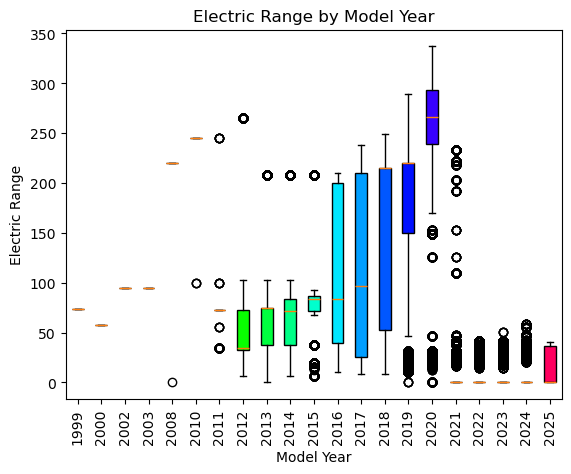

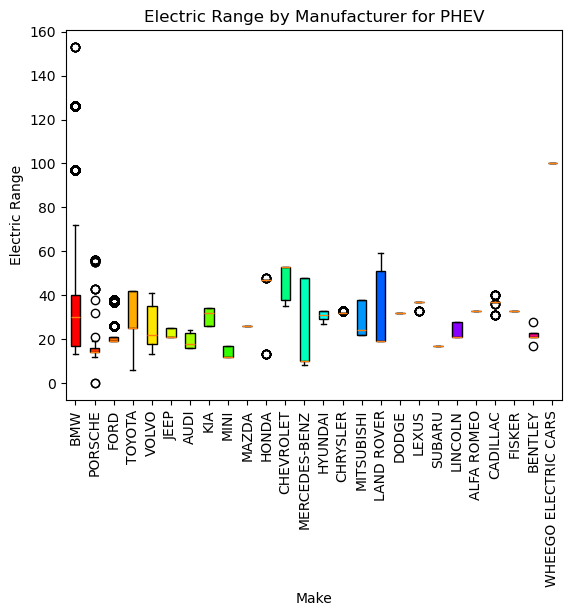

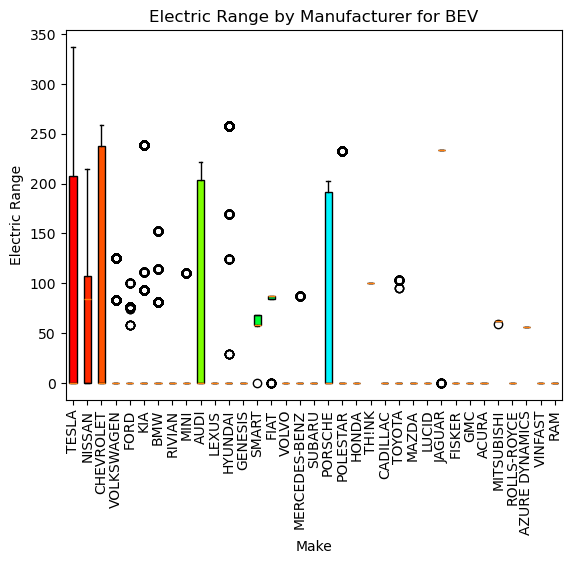

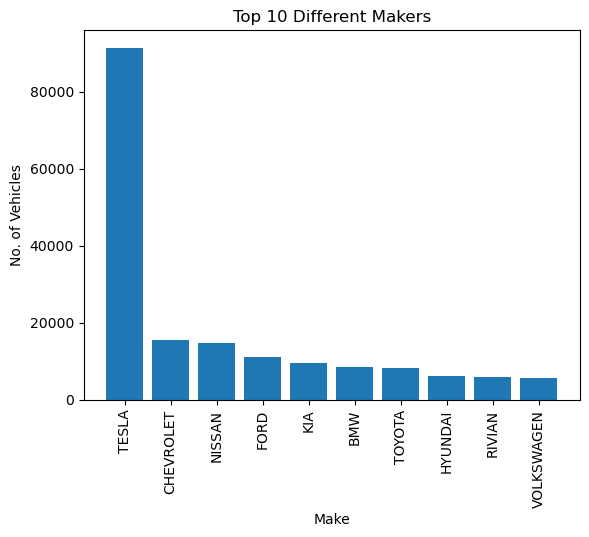

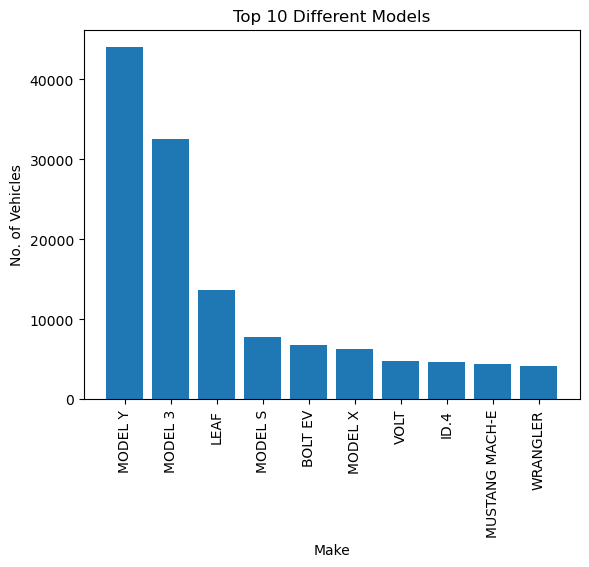

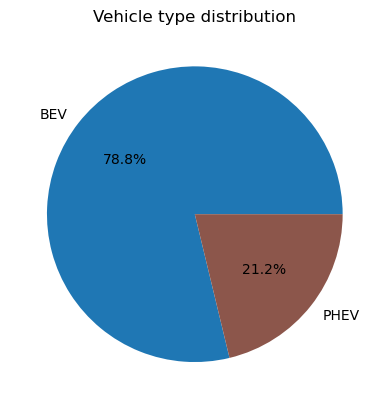

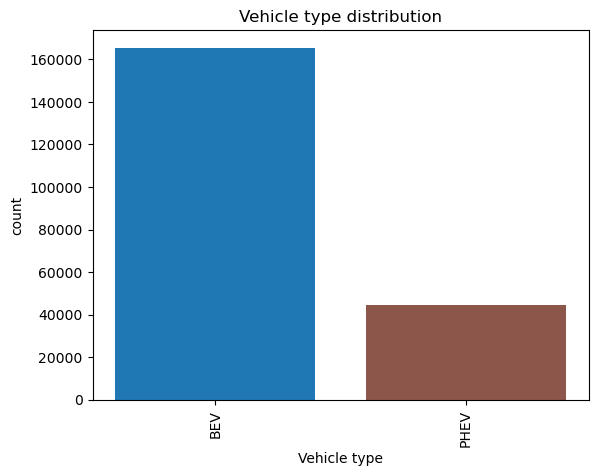

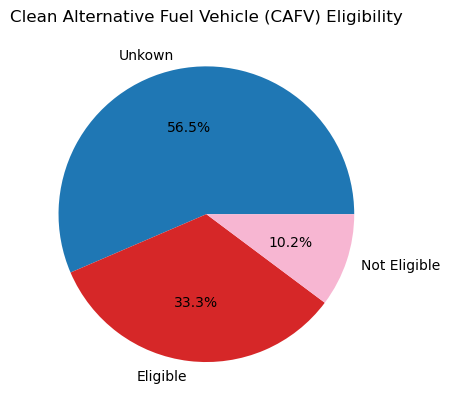

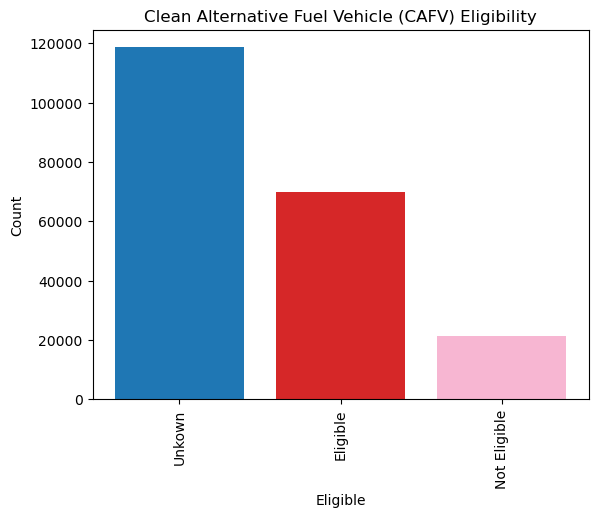

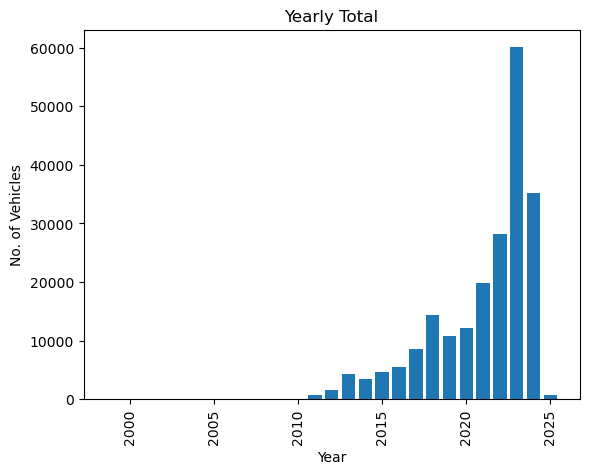

In [5]:
handler._plot = True
handler.create_boxplot(data=boxplot_data, patch_artist=True)
handler.create_boxplot(data=boxplot_data_PHEV, patch_artist=True)
handler.create_boxplot(data=boxplot_data_BEV, patch_artist=True)
handler.create_barplot(maker_data)
handler.create_barplot(model_data)
handler.create_piechart(car_type, patch_artist=True)
handler.create_barplot({
    'xlabel': 'Vehicle type',
    'ylabel': 'count',
    'title' : 'Vehicle type distribution',
    'y': handler._df['Electric Vehicle Type'].value_counts().to_list(),
    'x': handler._df['Electric Vehicle Type'].value_counts().index.to_list()
}, patch_artist=True)
handler.create_piechart(eligibility, patch_artist=True)
handler.create_barplot({
    'xlabel': 'Eligible',
    'ylabel': 'Count',
    'title' : 'Clean Alternative Fuel Vehicle (CAFV) Eligibility',
    'y': handler._df['Clean Alternative Fuel Vehicle (CAFV) Eligibility'].value_counts().to_list(),
    'x': handler._df['Clean Alternative Fuel Vehicle (CAFV) Eligibility'].value_counts().index.to_list()
}, patch_artist=True)
handler.create_barplot(yeartotal_barplot)